# Getting Started

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
image_dir = Path('../input/food41/images')

# Creating File DataFrame

In [4]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [5]:
image_df

,Filepath,Label
0,../input/food41/images/greek_salad/1330935.jpg,greek_salad
1,../input/food41/images/pancakes/3562559.jpg,pancakes
2,../input/food41/images/beef_carpaccio/484148.jpg,beef_carpaccio
3,../input/food41/images/french_fries/421038.jpg,french_fries
4,../input/food41/images/bread_pudding/689770.jpg,bread_pudding
...,...,...
10095,../input/food41/images/shrimp_and_grits/149216...,shrimp_and_grits
10096,../input/food41/images/sushi/2674024.jpg,sushi
10097,../input/food41/images/poutine/508222.jpg,poutine
10098,../input/food41/images/paella/265807.jpg,paella


In [6]:
image_df['Label'].value_counts()

cheesecake          100
baby_back_ribs      100
macarons            100
chicken_curry       100
caprese_salad       100
                   ... 
club_sandwich       100
chicken_wings       100
garlic_bread        100
huevos_rancheros    100
onion_rings         100
Name: Label, Length: 101, dtype: int64

# Train-Test Split

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Creating Generators

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


# Modeling

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training

In [1]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

NameError: name 'model' is not defined

# Results

In [18]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.75%


In [19]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

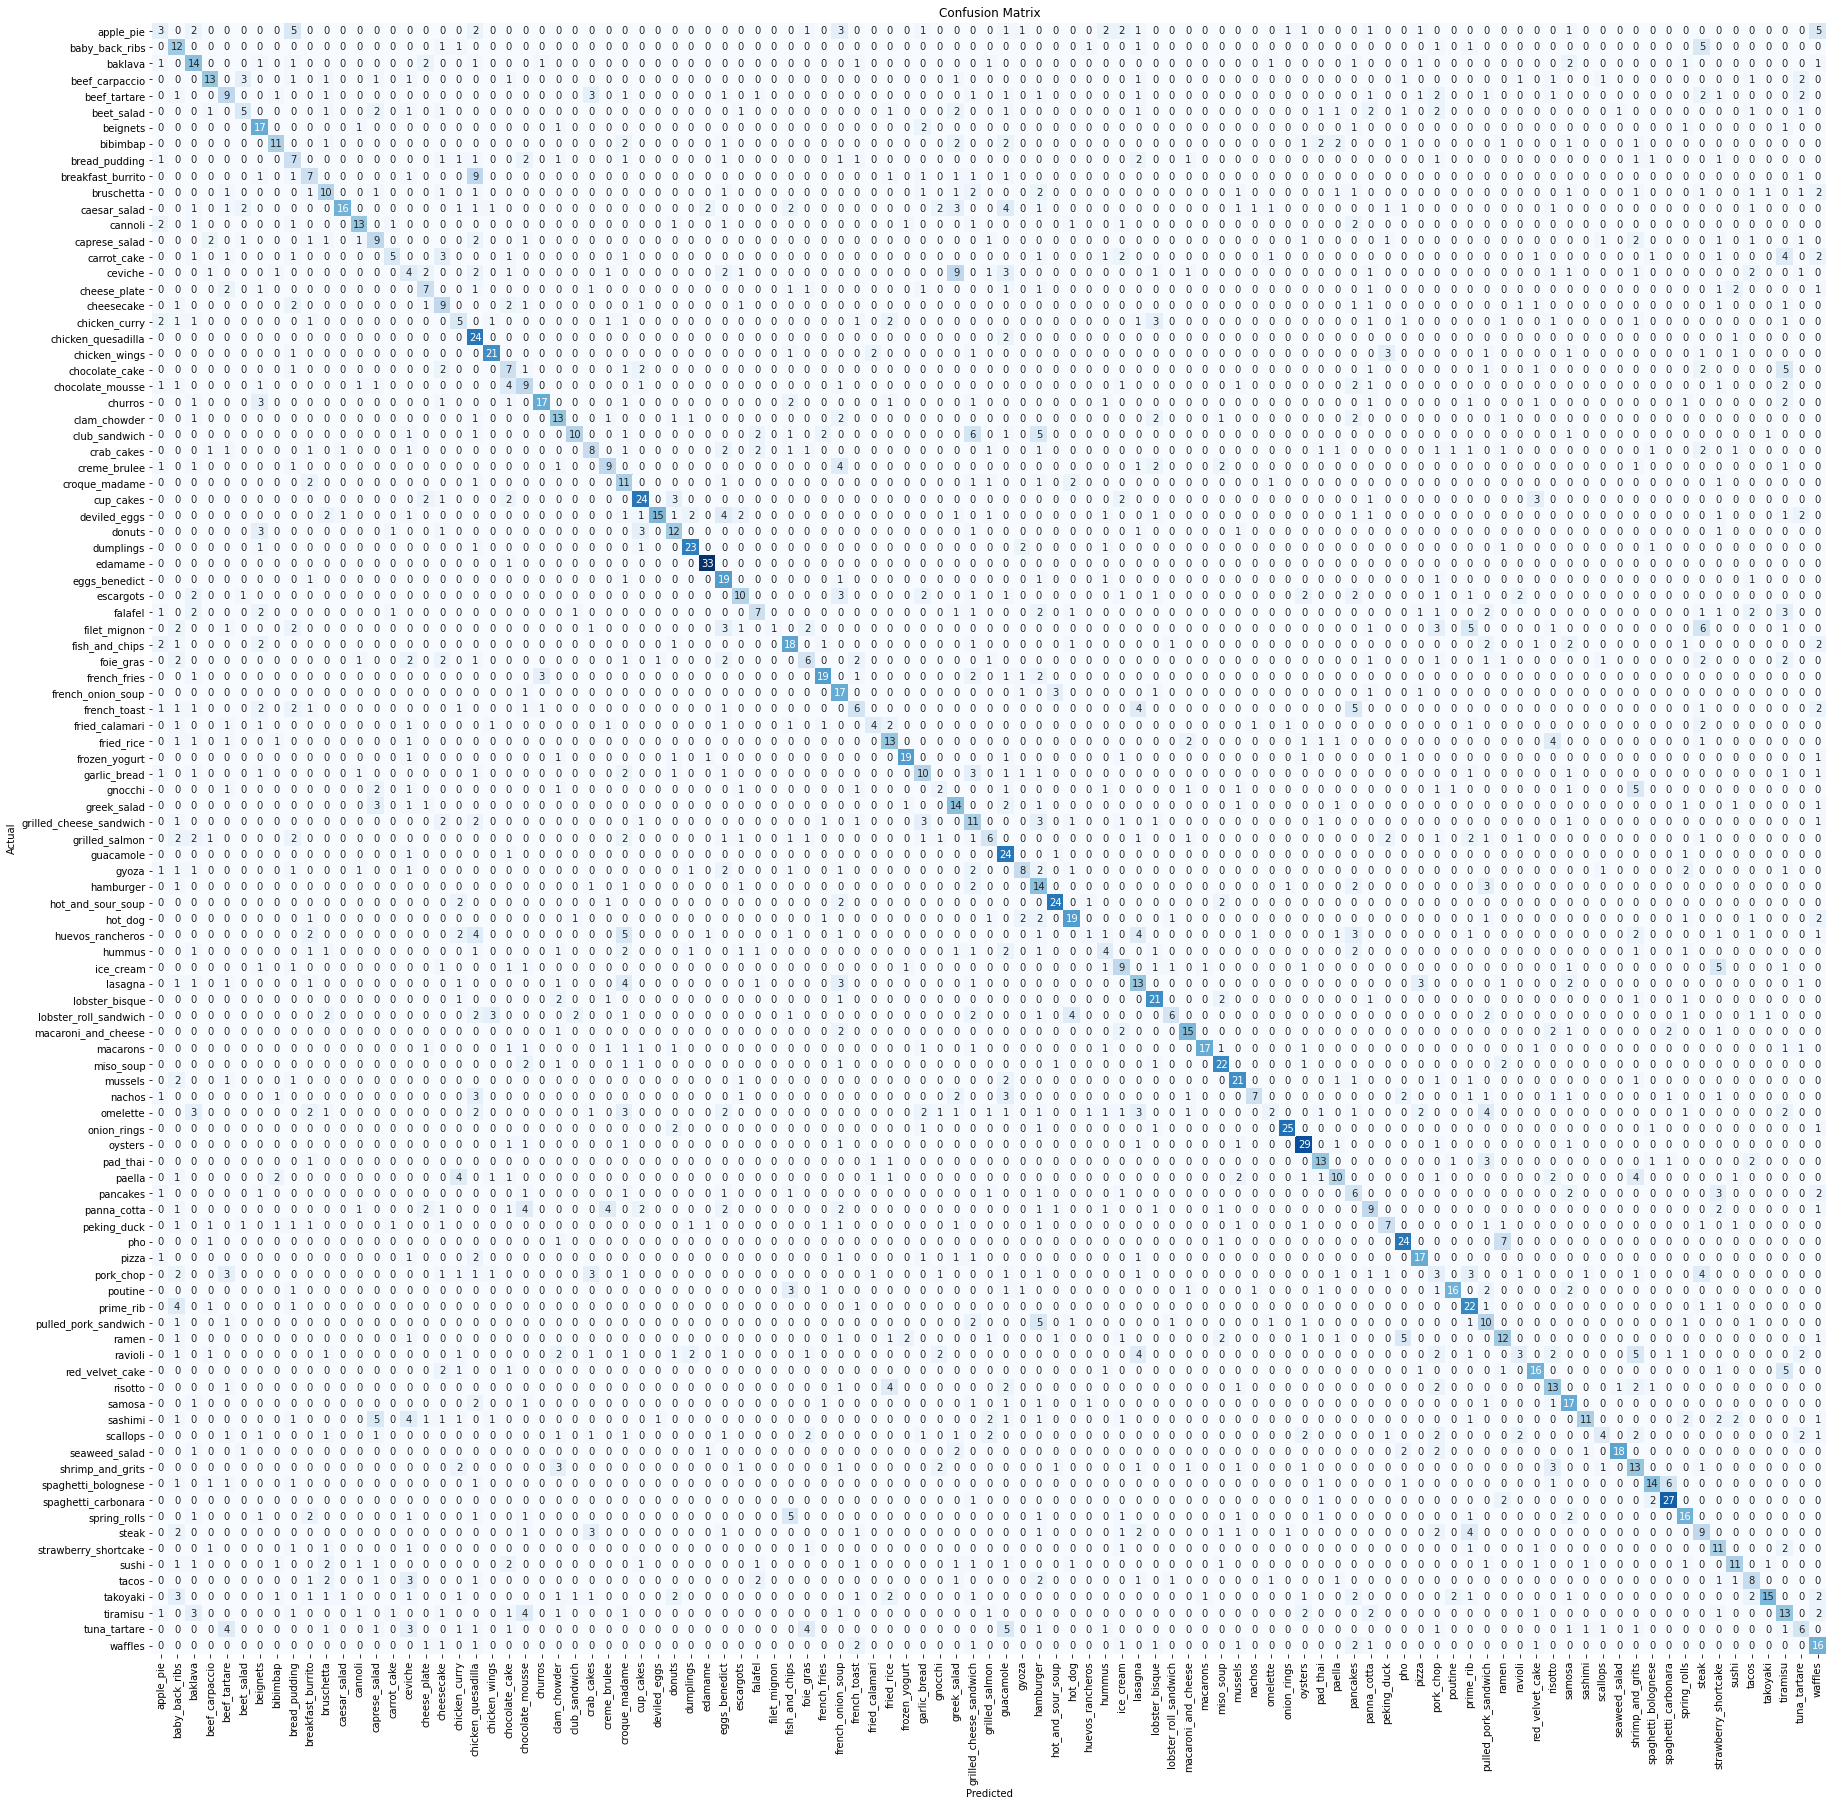

In [20]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.14      0.09      0.11        34
         baby_back_ribs       0.23      0.52      0.32        23
                baklava       0.30      0.47      0.37        30
         beef_carpaccio       0.52      0.43      0.47        30
           beef_tartare       0.28      0.27      0.28        33
             beet_salad       0.36      0.19      0.24        27
               beignets       0.42      0.71      0.53        24
               bibimbap       0.55      0.39      0.46        28
          bread_pudding       0.18      0.28      0.22        25
      breakfast_burrito       0.25      0.28      0.26        25
             bruschetta       0.33      0.30      0.32        33
           caesar_salad       0.84      0.36      0.51        44
                cannoli       0.59      0.50      0.54        26
          caprese_salad       0.32      0.

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/35iRdqY01co